# Facial_emotion_recognition

The project plan is to create  a emotion recognition software thatcan be deployed either in a web page or AWS

The project plan can be divded as such
<ol>
    <li> Get the data, understand and group the data in proper folder
    <li> Make training, validation and test set from the data
    <li> Create the model and train the model with training set
    <li> Test the model and evaluate the model
    <li> Deploy the model
</ol>
    


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch, os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import seaborn as sn
from random import random

from torch.nn import MSELoss
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils, models
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid


# 1. Getting the Data, Understanding and Grouping the data

We will use the Kaggle dataset from https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data

We would need to follow the instruction https://www.kaggle.com/docs/api to download the Public Token in order to use the Kaggle Public API

In [2]:
!pip install kaggle

In [3]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

challenges-in-representation-learning-facial-expression-recognition-challenge.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
if not os.path.exists(os.path.join(os.getcwd(), 'raw')):
  os.mkdir('raw')

!cp challenges-in-representation-learning-facial-expression-recognition-challenge.zip  raw
!unzip -o challenges-in-representation-learning-facial-expression-recognition-challenge.zip -d raw

Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: raw/example_submission.csv  
  inflating: raw/fer2013.tar.gz      
  inflating: raw/icml_face_data.csv  
  inflating: raw/test.csv            
  inflating: raw/train.csv           


There is a number of files in the zip. We would need to unzip the fer2013.tar.gz file to access the data

In [5]:
!tar -xf raw/fer2013.tar.gz --directory raw
!cp -r raw/fer2013 input

In [6]:
# using panda to load the data
df = pd.read_csv('input/fer2013/fer2013.csv') 

## take a look at the info
df.info()

## have a few glimpse into the data set
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


Based on the data from the webpage, we know that 
<ul>
    <li> emotion is the class label of data, y </li>
    <li> pixels is the data or x </li>
    <li> and usage is which stage the data is supposed to be used for </li></ul>

Let us see the break down of our dataset

Text(0.5, 1.0, 'Distribution of Usage')

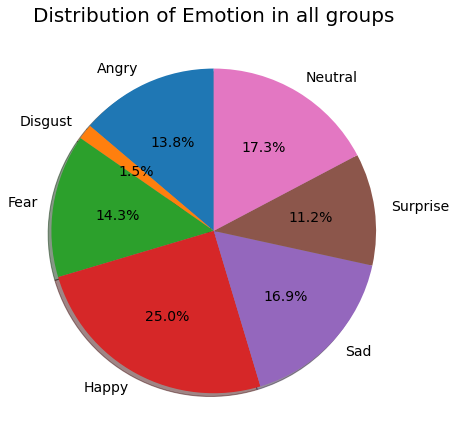

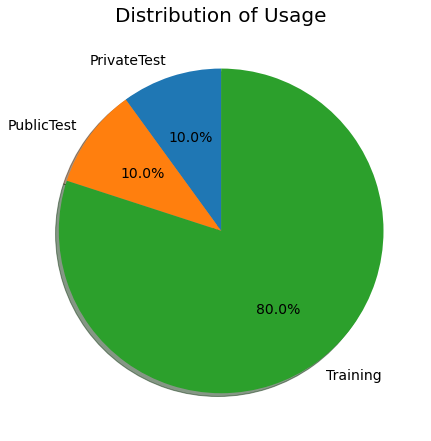

In [7]:
emotion_breakdown = df.groupby(['emotion'], as_index=False).count()

emotion_classes = {
    0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'
}

plt.figure(figsize=(16,10))
fig= plt.subplot(1, 2, 1)
plt.pie(emotion_breakdown.Usage, labels=emotion_classes.values(), autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'fontsize': 14})
plt.title('Distribution of Emotion in all groups', fontsize=20)

usage_breakdown = df.groupby(['Usage'], as_index=False).count()

usage_classes ={0:'PrivateTest', 1:'PublicTest', 2:'Training'}

plt.figure(figsize=(16,10))
fig= plt.subplot(1, 2, 2)
plt.pie(usage_breakdown.emotion, labels=usage_classes.values(), autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'fontsize': 14})
plt.title('Distribution of Usage', fontsize=20)



Text(0.5, 1.0, 'Distribution of Emotion in PrivateTest')

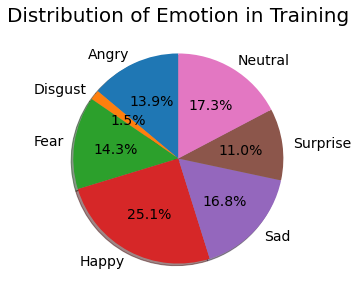

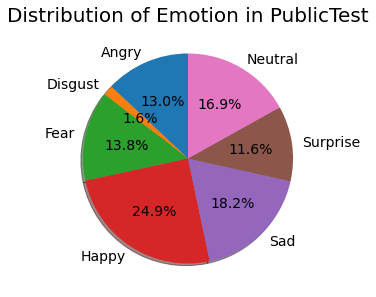

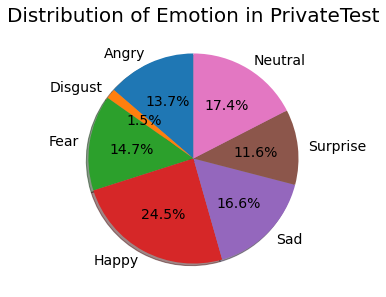

In [8]:
## getting the breakdown for training set
df_training = df[df['Usage']=='Training']

training_breakdown = df_training.groupby(['emotion'], as_index=False).count()

plt.figure(figsize=(16,10))
fig= plt.subplot(1, 3, 1)
plt.pie(training_breakdown.Usage, labels=emotion_classes.values(), autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'fontsize': 14})
plt.title('Distribution of Emotion in Training', fontsize=20)

##############################################################################

## getting the breakdown for validation set
df_validate = df[df['Usage']=='PublicTest']

validate_breakdown = df_validate.groupby(['emotion'], as_index=False).count()


plt.figure(figsize=(16,10))
fig= plt.subplot(1, 3, 2)
plt.pie(validate_breakdown.Usage, labels=emotion_classes.values(), autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'fontsize': 14})
plt.title('Distribution of Emotion in PublicTest', fontsize=20)

###############################################################################
## getting the breakdown for testing set
df_test = df[df['Usage']=='PrivateTest']

test_breakdown = df_test.groupby(['emotion'], as_index=False).count()

plt.figure(figsize=(16,10))
fig= plt.subplot(1, 3, 3)
plt.pie(test_breakdown.Usage, labels=emotion_classes.values(), autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'fontsize': 14})
plt.title('Distribution of Emotion in PrivateTest', fontsize=20)



From the distribution, we can observe that the training set amount to about 80% of the total training class size and 10% of the data is to be the validation set and the other 10% is to be the final test set

On distribution of emotion, we can see that the emotion type 'disgust' iss under-represented down here while the happy data set is quite over represented down here

Now let us try to understand which clas of the expression represents which expression ourselves!

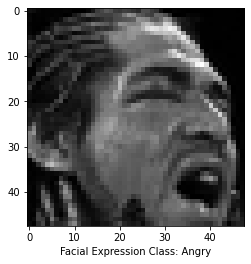

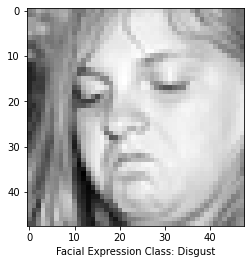

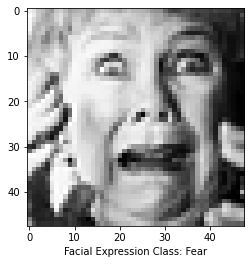

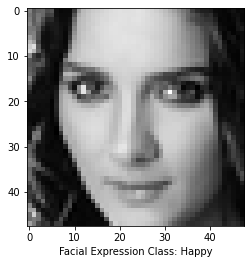

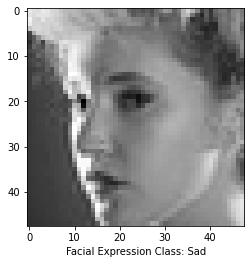

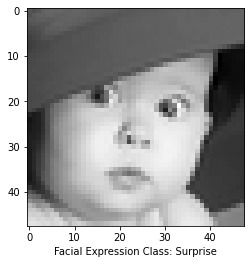

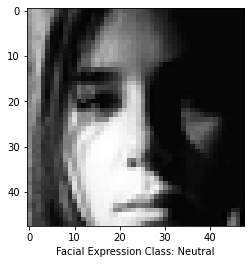

In [9]:
### To display the images
def makeframe(lst, n=48):
    for i in range(0, 48*48, n):  
        yield lst[i:i + n] 

# This function will help to show the images
def showimg(data):
    pixel = [int(i) for i in data[1].split(' ')]
    pixel = np.array(list(makeframe(pixel)))
    plt.imshow(pixel, cmap='gray')
    plt.xlabel(f'Facial Expression Class: {emotion_classes.get(data[0])}')
    plt.plot()

for i in range(7):
    plt.figure()
    f  = math.floor(random() * emotion_breakdown.Usage[i])
    showimg(df[df.emotion == i].values[f])

#### We tried to use FaceDetector as filter to filter for pictures that could be used for face detection but it was not successful. The amount of pictures that passed the check was too little for training

In [10]:
# from facenet_pytorch import MTCNN
# from PIL import Image
# import numpy.matlib
# import cv2

# mtcnn = MTCNN( post_process=False, device='cuda:0')

# rows_list = []
# i = 0
# for idx, row in df.iterrows():
#     pixel = [int(i) for i in row[1].split(' ')]
#     pixel = np.array(list(makeframe(pixel)))
#     im   = np.stack(((pixel * 255).astype(np.uint8),)*3, axis=-1)
#     print(im.shape)
# #     gray = Image.fromarray((pixel * 255).astype(np.uint8))
# #     im    = np.matlib.repmat(pixel, [1, 1, 3]);

#     face = mtcnn(im)
#     if face is not None:
#         path = str(i) + '.jpeg'
#         cv2.imwrite(path, pixel)
#         print("face found")
#         dict1 = {
#             'emotion' : row[0],
#             'pixels'  : row[1],
#             'Usage'   : row[2]
#         }
#         i = i + 1
#     else:
#         print("face not found")

#         rows_list.append(dict1)
        
# df_clean = pd.DataFrame(rows_list) 

# #     plt.imshow(pixel, cmap='gray')
# #     plt.xlabel(f'Facial Expression Class: {emotion_classes.get(row[0])}')
# #     plt.plot()

# torch.cuda.empty_cache() 

## df_clean.to_csv('fer2013_clean.csv')

## 2. Make training, validation and test set from the data 

In this part, our task will include
<ul>
    <li> Divide up the data into training, validation and finally testing set </li>
    <li> Define the transform that we will use for each data set </li>
    <li> Define the dataset class so we can transform the data or perform any customized transform</li>
    <li> Load the dataset with the PyTorch DataLoader to be ready for next stage </li>
    </ul>
    

In [11]:
# getting the dataset ready
df_test  = df[df.Usage == 'PrivateTest'].drop(['Usage'], axis=1).reset_index().drop(['index'], 1)
df_val   = df[df.Usage == 'PublicTest'].drop(['Usage'], axis=1).reset_index().drop(['index'], 1)
df_train = df[df.Usage == 'Training'].drop(['Usage'], axis=1).reset_index().drop(['index'], 1)

# differentiating between labels[1] and images[0]
train_images = df_train.iloc[:, 1]
train_labels = df_train.iloc[:, 0]
test_images  = df_test.iloc[:, 1]
test_labels  = df_test.iloc[:, 0]
val_images   = df_val.iloc[:, 1]
val_labels   = df_val.iloc[:, 0]

/tmp/ipykernel_12036/145672415.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_test  = df[df.Usage == 'PrivateTest'].drop(['Usage'], axis=1).reset_index().drop(['index'], 1)
/tmp/ipykernel_12036/145672415.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_val   = df[df.Usage == 'PublicTest'].drop(['Usage'], axis=1).reset_index().drop(['index'], 1)
/tmp/ipykernel_12036/145672415.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_train = df[df.Usage == 'Training'].drop(['Usage'], axis=1).reset_index().drop(['index'], 1)


### Define Transform for each dataset

<p> We will define the transform applicable for each dataset. Training set will have the most transform applied to it whereas the validation and test set will have similar transform.
    
<p> We will experiment with the transform

In [12]:
# this is for the transforms
train_transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.RandomCrop(48, padding=2, padding_mode='reflect'),
        transforms.RandomAffine(degrees=(-5,5), translate=(0.1,0.1)),
        transforms.RandomHorizontalFlip(),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,), inplace=True)
    ])

validation_transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

test_transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

In [13]:
# Creating the class for our dataset for the FER
class EmotionDataset(Dataset):
    
    def __init__(self, images, labels, transforms):
        self.X = images
        self.y = labels
        self.transforms = transforms
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        data = [int(m) for m in self.X[i].split(' ')]
        data = np.asarray(data).astype(np.uint8).reshape(48,48,1)
        data = self.transforms(data)
        label = self.y[i]
        return (data, label)
    
# assigning the transformed data

train_data      = EmotionDataset(train_images, train_labels, train_transform)
val_data        = EmotionDataset(val_images, val_labels, validation_transform)
test_data       = EmotionDataset(test_images, test_labels, test_transform)

dataset_class   = { 0 :train_data, 1 :val_data, 2 :test_data}
dataset_list    = ['Training', 'Validation', 'Testing']

Checkpoint to see whether transform is ok for the image

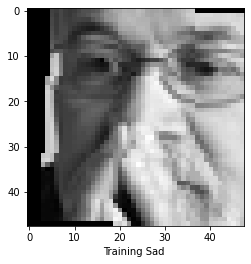

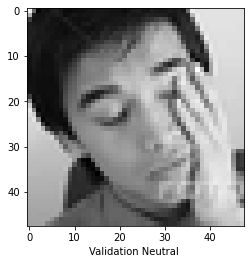

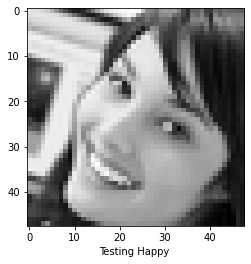

In [14]:
def showImgInDataset(data, text):
    img, label = data
   
    plt.figure()
    plt.imshow(torch.squeeze(img), cmap='gray')
    plt.xlabel(f'{text:} {emotion_classes.get(label)} ')
    plt.plot()

## Pick a random image to draw
for i, j in dataset_class.items():
    num  = math.floor(random() * len(j))
    showImgInDataset(j[num], dataset_list[i])

#### Now when the data is ready we will form 3 sets of data, namely train, validation and test dataset

In [15]:
batch_num     = 128

train_dl      = DataLoader(train_data, batch_num, shuffle=True, num_workers=4, pin_memory=True)
val_dl        = DataLoader(val_data, batch_num, num_workers=4, pin_memory=True)
test_dl       = DataLoader(test_data, batch_num, num_workers=4, pin_memory=True)

## 3. Create the model and train the model with training set

In [16]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

## class to support loading of data and loss calculation for training and validation steps
class EmotionBase(nn.Module):
    
    def __init__(self):
        super(EmotionBase, self).__init__()
        self.val_acc = 0.0
        
    # this takes is batch from training dl
    def training_step(self, batch):
        images, labels = batch
        images, labels = images.to(device), labels.to(device) # send to the appropriate device to train
        out            = self(images).to(device)         # calls the training model and generates predictions
        loss           = F.cross_entropy(out, labels)    # calculates loss compare to real labels using cross entropy
        return loss
    
    # this takes in batch from validation dl
    def validation_step(self, batch):
        images, labels = batch
        out            = self(images)
        loss           = F.cross_entropy(out, labels)     # calculate the loss using cross_entropy
        acc            = accuracy(out, labels)            # calls the accuracy function to measure the accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()    # finds out the mean loss of the epoch batch
        
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()       # finds out the mean acc of the epoch batch
        
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

        result = result['val_acc']                       # save the best model
        if result > self.val_acc:
            self.best_desc  = "{:.4f}".format((result)) + '.pth'
            self.best_model = model.state_dict()
            self.val_acc = result

In [17]:
from efficientnet_pytorch import EfficientNet

class Conv2dStaticSamePadding(nn.Conv2d):
    """2D Convolutions like TensorFlow's 'SAME' mode, with the given input image size.
       The padding mudule is calculated in construction function, then used in forward.
    """

    # With the same calculation as Conv2dDynamicSamePadding

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, image_size=None, **kwargs):
        super().__init__(in_channels, out_channels, kernel_size, stride, **kwargs)
        self.stride = self.stride if len(self.stride) == 2 else [self.stride[0]] * 2

        # Calculate padding based on image size and save it
        assert image_size is not None
        ih, iw = (image_size, image_size) if isinstance(image_size, int) else image_size
        kh, kw = self.weight.size()[-2:]
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            self.static_padding = nn.ZeroPad2d((pad_w // 2, pad_w - pad_w // 2,
                                                pad_h // 2, pad_h - pad_h // 2))
        else:
            self.static_padding = nn.Identity()

    def forward(self, x):
        x = self.static_padding(x)
        x = F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)
        return x



class EmotionDetection(EmotionBase):
    def __init__(self,n_channels, n_classes):
        
        super(EmotionDetection, self).__init__()
        
        self.effnet                  =  EfficientNet.from_pretrained('efficientnet-b0', num_classes=7)
        self.effnet._conv_stem       = Conv2dStaticSamePadding(1,32,kernel_size=(3,3), stride=(2,2),
                                                          image_size=(48),bias=False)

    def forward(self, input):
        x = self.effnet(input)
        return x
 
model = EmotionDetection(1,7)

print(model)

Loaded pretrained weights for efficientnet-b0
EmotionDetection(
  (effnet): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
         

In [18]:
random_seed   = 42
torch.manual_seed(random_seed);

In [19]:
model.eval()
for images, lbl in train_dl:
    print('shape of image: ', images.shape)
    out = model(images)
    print('shape of output: ', out.shape)
    print('Output: ', out[0])
    break

shape of image:  torch.Size([128, 1, 48, 48])
shape of output:  torch.Size([128, 7])
Output:  tensor([-0.1420, -0.1811, -0.0806,  0.1092, -0.1348, -0.1035,  0.0178],
       grad_fn=<SelectBackward0>)


#### Setting up the devices 

In [20]:
def get_default_device():
    """Select GPU or else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """A Dataloader to move data to device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Return batch number """
        return len(self.dl)

#### Verify that we are having GPU as device to work on

In [21]:
device = get_default_device()
###
device

device(type='cuda')

In [22]:
# load the data(train and valiation) to the device
train_dl        = DeviceDataLoader(train_dl, device)
val_dl          = DeviceDataLoader(val_dl, device)

#### Define steps for training

In [23]:
@torch.no_grad()    # this is for stopping the model from keeping track ofold parameters
def evaluate(model, val_loader):
    # This function will evaluate the model and give back the val acc and loss
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

# getting the current learning rate
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# this fit function follows the intuition of 1cycle lr
def fit(epochs, max_lr, model, train_loader=train_dl, val_loader=val_dl, 
        weight_decay=0, grad_clip=None, opt_func=torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []    #keep track of the evaluation results
    
    # setting upcustom optimizer including weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # setting up 1cycle lr scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # training
        model.train()
        train_losses = []                          ## used to collect all historical loss
        lrs = []                                   ## used to collect all learning rate
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            # record the lr
            lrs.append(get_lr(optimizer))
            sched.step()
            
        #validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [24]:
model = to_device(model, device)

In [25]:
evaluate(model, val_dl)

{'val_loss': 1.9265609979629517, 'val_acc': 0.22618533670902252}

In [26]:
### set the inital parameter for training
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
max_epoch = 35

#### Training the model

In [27]:
%%time
history = fit(max_epoch, max_lr, model, weight_decay=weight_decay, grad_clip=grad_clip)

Epoch [0], last_lr: 0.00006, train_loss: 1.9359, val_loss: 2.0319, val_acc: 0.0878
Epoch [1], last_lr: 0.00012, train_loss: 1.8139, val_loss: 1.8084, val_acc: 0.2600
Epoch [2], last_lr: 0.00022, train_loss: 1.7215, val_loss: 1.6176, val_acc: 0.3574
Epoch [3], last_lr: 0.00034, train_loss: 1.6120, val_loss: 1.5477, val_acc: 0.4022
Epoch [4], last_lr: 0.00048, train_loss: 1.4986, val_loss: 1.4149, val_acc: 0.4656
Epoch [5], last_lr: 0.00063, train_loss: 1.3979, val_loss: 1.3603, val_acc: 0.4823
Epoch [6], last_lr: 0.00076, train_loss: 1.3003, val_loss: 1.2808, val_acc: 0.5319
Epoch [7], last_lr: 0.00087, train_loss: 1.2394, val_loss: 1.2093, val_acc: 0.5455
Epoch [8], last_lr: 0.00095, train_loss: 1.1863, val_loss: 1.1836, val_acc: 0.5615
Epoch [9], last_lr: 0.00099, train_loss: 1.1388, val_loss: 1.1813, val_acc: 0.5689
Epoch [10], last_lr: 0.00100, train_loss: 1.1012, val_loss: 1.1455, val_acc: 0.5584
Epoch [11], last_lr: 0.00099, train_loss: 1.0567, val_loss: 1.1182, val_acc: 0.5810
Ep

#### Processing after training to save model and plot the training result

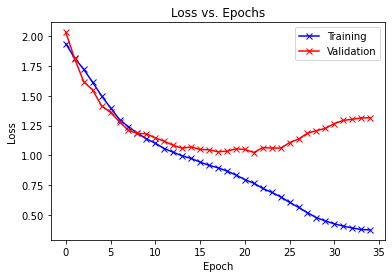

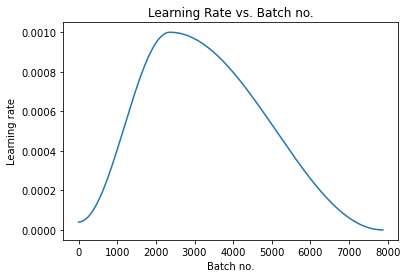

In [28]:
### /save the model 
path = "model_c7e0_" + model.best_desc
torch.save(model.best_model, path)

### Plot up the training and validation history to see if overfit
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. Epochs');
    
### Plot the learning rate
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
    
plot_losses(history)
plt.figure()
plot_lrs(history)

## 4. Test the model and evaluate the model

Now we will test our model with the test set 

In [29]:
model = EmotionDetection(1,7)
model.load_state_dict(torch.load("./model_c7e0_0.6620.pth"))    ## from trials
model = to_device(model, device)
model.eval()

Loaded pretrained weights for efficientnet-b0


EmotionDetection(
  (effnet): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
      

Let us now look at the confusion matrix

The overall accurate percentage is 0.6639732516021176
The per-class precision value is :
[0.58367347 0.7755102  0.54761905 0.83795782 0.51166667 0.799511
 0.61949686]
The per-class recall value is :
[0.58248473 0.69090909 0.52272727 0.8589306  0.51683502 0.78605769
 0.62939297]
The per-class fscore value is :
[0.58307849 0.73076923 0.53488372 0.84831461 0.51423786 0.79272727
 0.62440571]


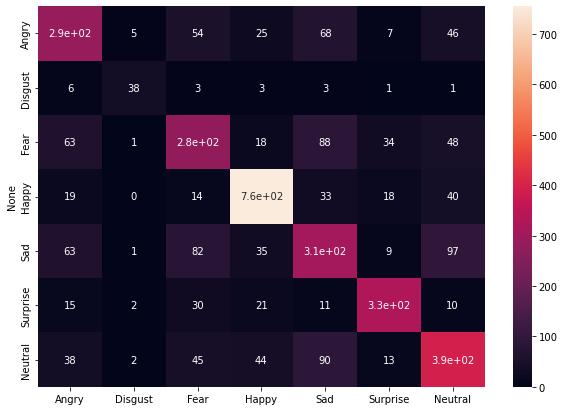

In [32]:
# Initialize the prediction and label lists(tensors)
pred_list   = torch.zeros(0,dtype=torch.long, device='cuda:0')
label_list  = torch.zeros(0,dtype=torch.long, device='cuda:0')

device
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_dl):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        pred_list=torch.cat([pred_list,preds.view(-1).cuda()])
        label_list=torch.cat([label_list,classes.view(-1).cuda()])

# Confusion matrix
conf_mat     = confusion_matrix(label_list.cpu().numpy(), pred_list.cpu().numpy())

emotion_list = list(emotion_classes.values())


df_cm = pd.DataFrame(conf_mat,index= [emotion_list], columns = emotion_list)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

## Total accuracy
print("The overall accurate percentage is {}".format(sum(conf_mat.diagonal())/conf_mat.sum()))

## Precision per class
precision,recall,fscore,support = precision_recall_fscore_support(label_list.cpu().numpy(),
                                                                  pred_list.cpu().numpy()) #,
                                                               #   labels=[emotion_list])


print("The per-class precision value is :")
print(precision)
print("The per-class recall value is :" )
print(recall)
print("The per-class fscore value is :" )
print(fscore)

## 5. Deploy the model 

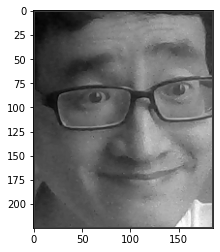

In [33]:
# import the necessary packages
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
# construct the argument parser and parse the arguments

frame = cv2.imread('deploy/myself.png',0)
plt.imshow(frame, cmap='gray')
plt.show()

In [34]:
# resize image
dim = (48, 48)
im = cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)

im = transforms.functional.to_pil_image(im)
im = transforms.functional.to_grayscale(im)
im = transforms.ToTensor()(im).unsqueeze(0)

im = to_device(im, device)
im.device

# print(im)
tensor = model(im)
# print(tensor)

pred = torch.max(tensor, dim=1)[1].tolist()
label = emotion_list[pred[0]]
print("I am feeling " + label)

I am feeling Happy


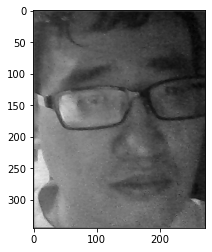

I am feeling Neutral


In [35]:
frame2 = cv2.imread('deploy/myself3.png',0)
plt.imshow(frame2, cmap='gray')
plt.show()

dim = (48, 48)
im2 = cv2.resize(frame2, dim, interpolation = cv2.INTER_AREA)

im2 = transforms.functional.to_pil_image(im2)
im2 = transforms.functional.to_grayscale(im2)
im2 = transforms.ToTensor()(im2).unsqueeze(0)

im2= to_device(im2, device)
im2.device

# print(im)
tensor2 = model(im2)
# print(tensor)

pred2 = torch.max(tensor2, dim=1)[1].tolist()
label2 = emotion_list[pred2[0]]
print("I am feeling " + label2)

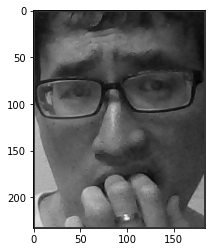

I am feeling Fear


In [36]:
frame3 = cv2.imread('deploy/myself20.png',0)
plt.imshow(frame3, cmap='gray')
plt.show()

dim = (48, 48)
im3 = cv2.resize(frame3, dim, interpolation = cv2.INTER_AREA)

im3 = transforms.functional.to_pil_image(im3)
im3 = transforms.functional.to_grayscale(im3)
im3 = transforms.ToTensor()(im3).unsqueeze(0)

im3= to_device(im3, device)
im3.device

# print(im)
tensor3 = model(im3)
# print(tensor)

pred3 = torch.max(tensor3, dim=1)[1].tolist()
label3 = emotion_list[pred3[0]]
print("I am feeling " + label3)

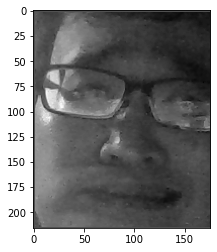

I am feeling Angry


In [37]:
frame4 = cv2.imread('deploy/myself7.png',0)
plt.imshow(frame4, cmap='gray')
plt.show()

dim = (48, 48)
im4 = cv2.resize(frame4, dim, interpolation = cv2.INTER_AREA)

im4 = transforms.functional.to_pil_image(im4)
im4 = transforms.functional.to_grayscale(im4)
im4 = transforms.ToTensor()(im4).unsqueeze(0)

im4= to_device(im4, device)
im4.device

# print(im)
tensor4 = model(im4)
# print(tensor)

pred4 = torch.max(tensor4, dim=1)[1].tolist()
label4 = emotion_list[pred4[0]]
print("I am feeling " + label4)

## Conclusion

Now we have the model to predict emotion from images